In [1]:
%matplotlib inline
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
from bs4 import BeautifulSoup
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.ensemble import ExtraTreesClassifier

In [2]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
py.init_notebook_mode(connected = True)

In [3]:
train = pd.read_csv('mbti_1.csv')
us = pd.read_csv('Users.csv')
ps = pd.read_csv('ForumMessages.csv')
mbti = {'I' : 'Introversion', 'E' : 'Extroversion', 'N' : 'Intuitions', 'S' : 'Sensing', 'T' : 'Thinking', 'F' : 'Feeling', 'J' : 'Judging', 'P' : 'Perceiving'}

In [4]:
print(train.shape)

(8675, 2)


In [5]:
train.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [6]:
ps.head()

,Id,ForumTopicId,PostUserId,PostDate,ReplyToForumMessageId,Message,Medal,MedalAwardDate
0,1,1,478,04/28/2010 23:13:08,NaN,<div>In response to a comment on the No Free H...,NaN,NaN
1,2,2,606,04/29/2010 15:48:46,NaN,"Hi, I'm interested in participating in the con...",NaN,NaN
2,3,2,478,04/29/2010 15:48:46,NaN,"Tanya,<div><br></div><div>Good to hear from yo...",NaN,NaN
3,4,2,368,04/29/2010 15:48:46,NaN,"Hi Tanya, <br><br>Kaggle will maintain a ratin...",NaN,NaN
4,5,3,634,04/30/2010 14:32:29,NaN,"Hi,<br><br>I just read in csv files and I've g...",NaN,NaN


In [7]:
ps.shape

(1727978, 8)

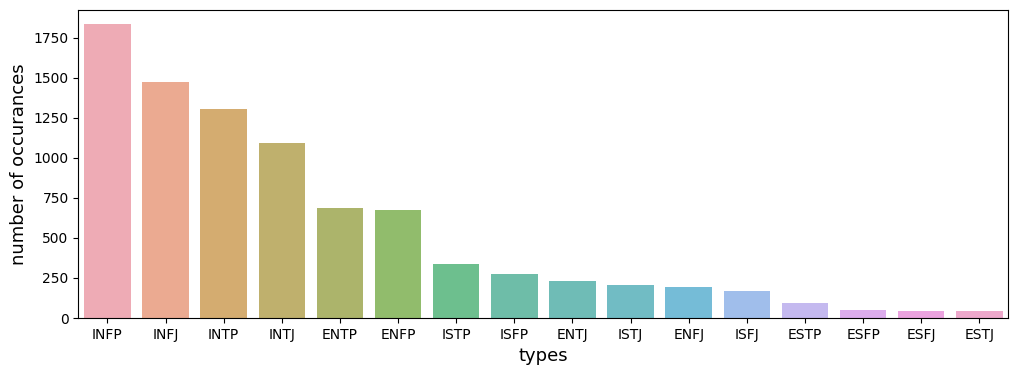

In [8]:
cnt_srs = train['type'].value_counts()
plt.figure(figsize = (12,4))
sns.barplot( x = cnt_srs.index,y = cnt_srs.values, alpha = 0.8)
plt.ylabel('number of occurances', fontsize = 13)
plt.xlabel('types', fontsize = 13)
plt.show()

In [9]:
ps['Message'] = ps['Message'].fillna('')

In [12]:
ps_join = ps.groupby('PostUserId')['Message'].agg(lambda col: ' '.join(col)).reset_index()
ps_join.head()

,PostUserId,Message
0,62,"tes David, just a quick note to say thanks for..."
1,368,"Hi Tanya, <br><br>Kaggle will maintain a ratin..."
2,381,"<p>Hi Sergei,</p>\r\n<p>Compiled Matlab p-code..."
3,387,<p>From an economic perspective let's look at ...
4,389,<p>There's still one more confusion.. what doe...


In [11]:
etc = ExtraTreesClassifier(n_estimators = 20, max_depth = 4, n_jobs = -1)
tfidf = TfidfVectorizer(ngram_range = (1,1), stop_words = 'english')
tsvd = TruncatedSVD(n_components = 10)
model = Pipeline([('tfidifi' , tfidf),('tsvd1', tsvd),('etc',etc)])

In [12]:
kfolds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1)

In [13]:
np.random.seed(1)

scoring = {'acc':'accuracy',
          'neg_log_loss': 'neg_log_loss',
           'f1_micro':'f1_micro'}

results = cross_validate(model, train['posts'], train['type'], cv= kfolds, scoring = scoring, n_jobs = 1)

In [14]:
print("CV Accuracy: {:0.4f}(+/- {:0.4f})".format(np.mean(results['test_acc']),np.std(results['test_acc'])))
print("CV F1: {:0.4f}(+/- {:0.4f})".format(np.mean(results['test_f1_micro']),np.std(results['test_f1_micro'])))
print("CV Logloss: {:0.4f}(+/- {:0.4f})".format(np.mean(results['test_neg_log_loss']),np.std(results['test_neg_log_loss'])))


CV Accuracy: 0.3009(+/- 0.0169)
CV F1: 0.3009(+/- 0.0169)
CV Logloss: -2.1370(+/- 0.0172)


In [11]:
def cleanText(text):
    text = BeautifulSoup(text, 'lxml').text
    text = re.sub(r'\|\|\|',r'',text)
    text = re.sub(r'http\S+', r'<URL', text)
    return text

In [16]:
train['clean_posts'] = train['posts'].apply(cleanText)

C:\Users\farhe\AppData\Local\Temp\ipykernel_10068\2346620367.py:2: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



In [17]:
np.random.seed(1)

tfidf2 = CountVectorizer(ngram_range = (1,1), stop_words = 'english', lowercase = True, max_features = 5000)

model_nb = Pipeline([('tfidf1' , tfidf2), ('nb' , MultinomialNB())])

results_nb = cross_validate(model_nb, train['clean_posts'], train['type'], cv= kfolds, scoring = scoring, n_jobs = -1)

In [18]:
print("CV Accuracy: {:0.4f}(+/- {:0.4f})".format(np.mean(results_nb['test_acc']),np.std(results_nb['test_acc'])))
print("CV F1: {:0.4f}(+/- {:0.4f})".format(np.mean(results_nb['test_f1_micro']),np.std(results_nb['test_f1_micro'])))
print("CV Logloss: {:0.4f}(+/- {:0.4f})".format(np.mean(results_nb['test_neg_log_loss']),np.std(results_nb['test_neg_log_loss'])))


CV Accuracy: 0.5622(+/- 0.0114)
CV F1: 0.5622(+/- 0.0114)
CV Logloss: -6.1920(+/- 0.3672)


In [19]:
np.random.seed(1)

tfidf2 = CountVectorizer(ngram_range = (1,1), stop_words = 'english', lowercase = True, max_features = 5000)

model_lr = Pipeline([('tfidf1' , tfidf2), ('lr' , LogisticRegression(class_weight = "balanced", C=0.005, max_iter=1000))])

results_lr = cross_validate(model_lr, train['clean_posts'], train['type'], cv= kfolds, scoring = scoring, n_jobs = -1)

In [20]:
print("CV Accuracy: {:0.4f}(+/- {:0.4f})".format(np.mean(results_lr['test_acc']),np.std(results_lr['test_acc'])))
print("CV F1: {:0.4f}(+/- {:0.4f})".format(np.mean(results_lr['test_f1_micro']),np.std(results_lr['test_f1_micro'])))
print("CV Logloss: {:0.4f}(+/- {:0.4f})".format(np.mean(results_lr['test_neg_log_loss']),np.std(results_lr['test_neg_log_loss'])))


CV Accuracy: 0.6561(+/- 0.0135)
CV F1: 0.6561(+/- 0.0135)
CV Logloss: -1.3090(+/- 0.0136)


In [21]:
train_sizes, train_scores, test_scores = learning_curve(model_lr, train['clean_posts'], train['type'], cv = kfolds, n_jobs = -1, scoring = 'f1_micro', train_sizes = np.linspace(.1,1.0,10), random_state=1)

In [22]:
def plot_learning_curve(X, y, train_sizes, train_scores, test_scores, title ='', ylim=None, figsize=(14,8)):
    
    plt.figure(figsize=figsize)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes,train_scores_mean-train_scores_std,train_scores_mean+train_scores_std, alpha = 0.1, color = 'r' )
    plt.fill_between(train_sizes,test_scores_mean-test_scores_std,test_scores_mean+test_scores_std, alpha = 0.1, color = 'g' )
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color = 'r', label = 'training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color = 'g', label = 'cross-validation score')
    
    plt.legend(loc="best")
    return plt

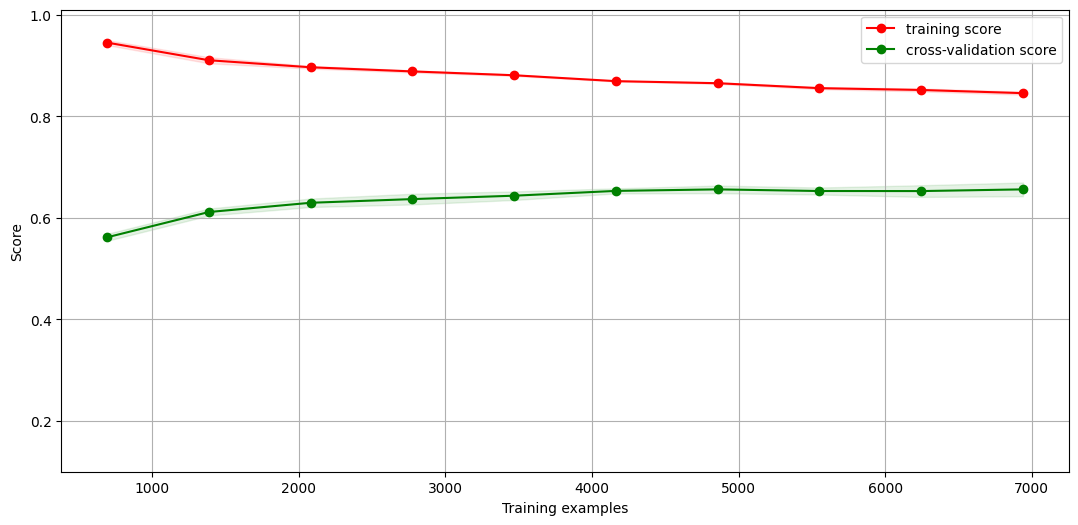

In [23]:
plot_learning_curve(train['posts'], train['type'], train_sizes, train_scores, test_scores, ylim=(0.1,1.01), figsize=(13,6))
plt.show()

In [24]:
ps_join['clean_comments'] = ps_join['Message'].apply(cleanText)

C:\Users\farhe\AppData\Local\Temp\ipykernel_10068\2346620367.py:2: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



In [25]:
model_lr.fit(train['clean_posts'], train['type'])
pred_all = model_lr.predict(ps_join['clean_comments'])

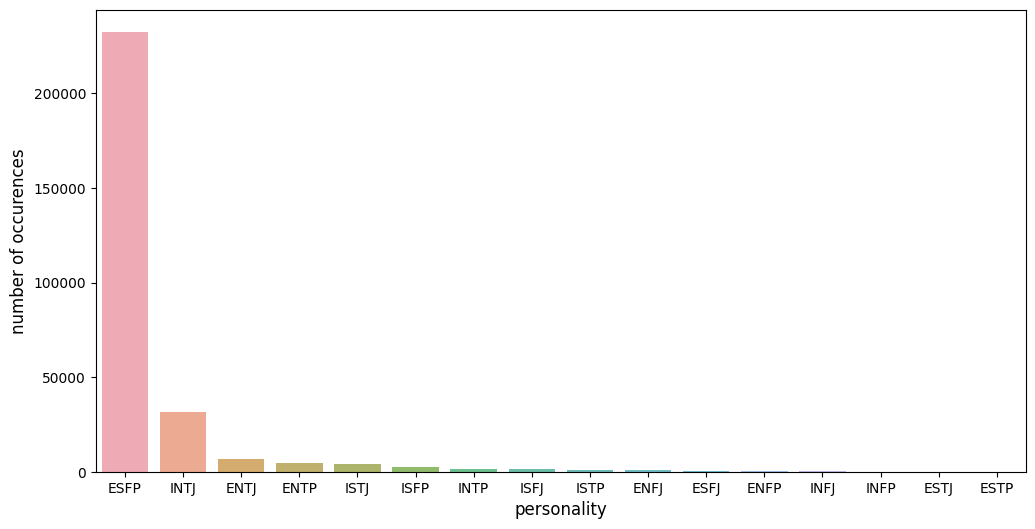

In [26]:
cnt_all = np.unique(pred_all, return_counts = True)

pred_df = pd.DataFrame({'personality': cnt_all[0], 'count': cnt_all[1]}, columns=['personality', 'count'], index=None)

pred_df.sort_values('count', ascending = False, inplace = True)

plt.figure(figsize=(12,6))
sns.barplot(x = pred_df['personality'], y = pred_df['count'], alpha = 0.8)
plt.ylabel('number of occurences' , fontsize = 12)
plt.xlabel('personality' , fontsize=12)
plt.show()

In [27]:
pred_df['percent'] = pred_df['count']/pred_df['count'].sum()

In [28]:
pred_df['description'] = pred_df['personality'].apply(lambda x: " ".join([mbti[l] for l in list(x)] ))

In [29]:
 pred_df
    

,personality,count,percent,description
5,ESFP,232549,0.812061,Extroversion Sensing Feeling Perceiving
10,INTJ,31329,0.109401,Introversion Intuitions Thinking Judging
2,ENTJ,6463,0.022569,Extroversion Intuitions Thinking Judging
3,ENTP,4437,0.015494,Extroversion Intuitions Thinking Perceiving
14,ISTJ,4069,0.014209,Introversion Sensing Thinking Judging
13,ISFP,2472,0.008632,Introversion Sensing Feeling Perceiving
11,INTP,1424,0.004973,Introversion Intuitions Thinking Perceiving
12,ISFJ,1236,0.004316,Introversion Sensing Feeling Judging
15,ISTP,1023,0.003572,Introversion Sensing Thinking Perceiving
0,ENFJ,680,0.002375,Extroversion Intuitions Feeling Judging


In [30]:
labels = pred_df['description']
sizes = pred_df['percent']*100

trace = go.Pie(labels = labels, values = sizes)
layput = go.Layout(title = 'kaggle user personality distribution')

data = [trace]
fig = go.Figure(data = data, layout = layput)
py.iplot(fig)